In [2]:
import xgboost as xgb
import sklearn
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import ipympl
import seaborn as sns
import useful_functions
import scipy
from scipy.stats import gaussian_kde
print('Using xgboost version %s' % xgb.__version__)
print('Using scikit-learn version %s' % sklearn.__version__)
%matplotlib widget

Using xgboost version 1.4.2
Using scikit-learn version 1.0


### Prep data and choose input variables

In [30]:
# import data, remove non-necessary columns
#DATA_LOCATION = r'C:\Users\xrnogueira\Documents\Data\NO2_stations\master_no2_daily.csv' # at work
DATA_LOCATION = r'C:\Users\xavie\Documents\master_no2_daily_test_500_rows_nov30.csv'  # at home
in_data = pd.read_csv(DATA_LOCATION)
keep_cols = ['mean_no2', 'Z_r', 'weekend', 'sp', 'swvl1', 't2m', 'tp', 'u10', 'v10', 'blh', 'u100', 'v100', 'p_roads_1000', 's_roads_1700', 's_roads_3000', 'tropomi', 'pod_den_1100']
in_data = in_data[keep_cols]


# standardize column headers
for col in list(in_data.columns):
        if in_data[col].dtypes == object:
            in_data[col].replace(' ', '_', regex=True, inplace=True)
        if ' ' in str(col)[:-1]:
            new = str(col).replace(' ', '_')
            if new[-1] == '_':
                new = new[:-1]
            in_data.rename(columns={str(col): new}, inplace=True)
        
            
in_data.head()

,mean_no2,Z_r,weekend,sp,swvl1,t2m,tp,u10,v10,blh,u100,v100,p_roads_1000,s_roads_1700,s_roads_3000,tropomi,pod_den_1100
0,33.291667,0.0,0,86911.01557,0.405454,269.739805,0.002423,-1.080268,0.661982,114.434598,-0.728227,1.286281,6.050956,4.945142,12.756178,1.410000e+16,3859.171798
1,8.686957,0.0,0,99059.12038,0.324161,267.119291,0.001630,1.778470,-1.075310,447.432957,0.198183,0.041495,4.169124,6.045182,43.158852,2.582650e+15,8356.886382
2,4.715789,0.0,0,83312.93520,0.395461,269.165219,0.000286,-0.396269,0.784059,1116.898926,-0.194601,1.562163,0.000000,3.294103,9.029836,1.372230e+15,2669.920134
3,4.666667,0.0,0,97988.29041,0.466480,271.870177,0.005791,1.274388,0.326976,519.989826,0.894252,1.814834,8.144184,0.519936,2.320980,2.442060e+15,2497.753292
4,18.681818,0.0,1,98059.90825,0.187030,288.631371,0.004175,-0.139594,0.102949,254.542703,0.575536,0.183747,7.960621,2.645854,9.867187,2.769600e+15,3943.426583


### Make density chart to visualize continous variable distributions

In [31]:
# make a separate dataframe formatted for Seaborn plotting
cont_df = in_data.drop('weekend', axis=1)
cols = list(cont_df.columns)
print(cols)
dfs = []
for i, val in enumerate(cols):
    sub_df = pd.DataFrame()
    sub_df['value'] = in_data[[val]]
    sub_df['std_val'] = (sub_df - sub_df.mean())/sub_df.std()
    sub_df['key'] = val
    dfs.append(sub_df)
    
plot_df = pd.concat(dfs)
print('Continous variables: %s' % plot_df.key.unique())
plot_df.head()


['mean_no2', 'Z_r', 'sp', 'swvl1', 't2m', 'tp', 'u10', 'v10', 'blh', 'u100', 'v100', 'p_roads_1000', 's_roads_1700', 's_roads_3000', 'tropomi', 'pod_den_1100']
Continous variables: ['mean_no2' 'Z_r' 'sp' 'swvl1' 't2m' 'tp' 'u10' 'v10' 'blh' 'u100' 'v100'
 'p_roads_1000' 's_roads_1700' 's_roads_3000' 'tropomi' 'pod_den_1100']


,value,std_val,key
0,33.291667,3.299860,mean_no2
1,8.686957,0.052124,mean_no2
2,4.715789,-0.472056,mean_no2
3,4.666667,-0.478540,mean_no2
4,18.681818,1.371411,mean_no2


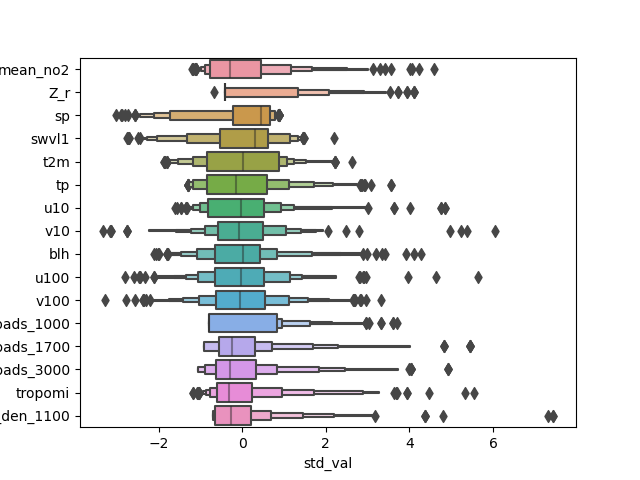

In [32]:
%matplotlib widget
ax = sns.boxenplot(x='std_val', y='key', data=plot_df)

### Set up training/test data and build optimal model parameters using GridSearchCV

In [33]:
# Make a XGBoost DMatrix object
ytr = in_data['mean_no2'].values # define y variable
xtr = in_data.drop('mean_no2', axis=1) # define x variables
xgdata = xgb.DMatrix(xtr, ytr, missing=np.NaN) # y values are the 'labels' of a DMatrix

In [35]:
# split data into train and test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(xtr,ytr,test_size = 0.10, random_state = 101) 

In [36]:
# set up parameter grid and interate over XGBoost model pareter sets
from sklearn.model_selection import GridSearchCV
gamme_range = list(np.arange(0, 2, 0.5))
eta_range = list(np.arange(0.05, 0.5, 0.05))
lambda_range = list(np.arange(0.6, 1.4, 0.2))
min_child_weight_range = list(np.arange(1, 21, 5))
max_depth_range = list(np.arange(4, 7 , 1))

param_grid = {'gamma': gamme_range, 'eta' : eta_range , 'reg_lambda' : lambda_range, 'min_child_weight' : min_child_weight_range, 
              'max_depth' : max_depth_range, 'booster' : ['gbtree']}

# this is the scikit-learn XGBoost interface, which allows sklearn functions like .fit() to be used
xgb_model = xgb.XGBRegressor('reg:squarederror')
xgb_model.fit(X_train, y_train) 

# clf stores
xgb_iters = GridSearchCV(xgb_model, param_grid, cv=5, scoring='r2', verbose=1, refit=True, return_train_score=True)
xgb_iters.fit(X_train, y_train)
print('Best parameter set: %s' % xgb_iters.best_params_) 

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best parameter set: {'booster': 'gbtree', 'eta': 0.05, 'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 1, 'reg_lambda': 0.6}


### Make predictions and assess feature importance

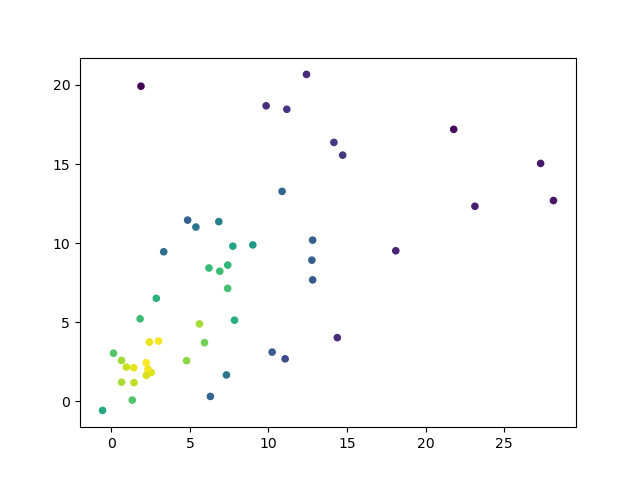

Text(1, 15, 'R2 = -0.01')

In [61]:
# print best parameter after tuning 
%matplotlib widget
#best_params_test = {'booster': 'gbtree', 'eta': 0.05, 'gamma': 1.0, 'max_depth': 6, 'min_child_weight': 6, 'reg_lambda': 0.6, 'eval_metric':'squarederror'}
#model = xgb.XGBRegressor(eta=0.05, gamma=1.0, max_depth=6, min_child_weight=6, reg_lambda=0.6, eval_metric=r2_score)
model = xgb_iters
grid_predictions = model.predict(X_test) 

# Calculate the point density
xy = np.vstack([grid_predictions,y_test])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(grid_predictions, y_test, c=z, s=20)
plt.show()

plt.title('XGBoost - Inputs: Month, weekend, monthly mean tropomi NO2')
plt.plot(np.arange(0, 60, 0.1), np.arange(0, 60, 0.1), c='red')
plt.xlim(0, np.max(grid_predictions))
plt.ylim(0, np.max(y_test))
plt.xlabel('Predicted NO2 concentration')
plt.ylabel('Actual daily NO2 concentration')
plt.text(0, 22.5, xgb_iters.best_params_, fontsize='x-small')
plt.text(1, 15, 'R2 = %s' % round(r2_score(y_test, grid_predictions), 2), fontsize='large')

In [40]:
# calculate performance metrics
print('R2 = %s' % r2_score(y_test, grid_predictions))
print('mean_sqrd_error = %s' % mean_squared_error(y_test, grid_predictions))

R2 = -0.010654916570253414
mean_sqrd_error = 33.78598988653527


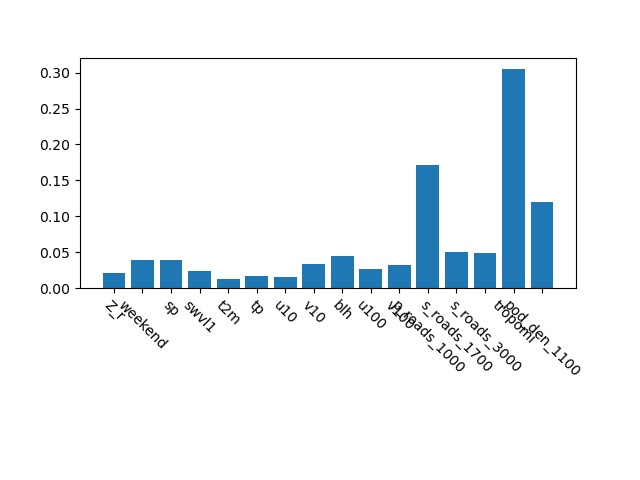

In [42]:
%matplotlib widget
model = xgb_iters.best_estimator_
x = range(len(model.feature_importances_))
plt.bar(x, model.feature_importances_)
plt.xticks(x, model.get_booster().feature_names, rotation=-45)
plt.subplots_adjust(bottom=0.40)
plt.show()

### Compare with straight regression

In [43]:
# remove nan values (incompatible w/ linear regression)
l_in_data = in_data
l_in_data.dropna(inplace=True)

ytrl = l_in_data['mean_no2'].values # define y variable
xtrl = l_in_data.drop('mean_no2', axis=1) 
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(xtrl, ytrl ,test_size = 0.15, random_state = 101) 

In [44]:
# set up multiple regression model
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train_l, y_train_l)

LinearRegression()

Text(1, 50, 'R2 = 0.21')

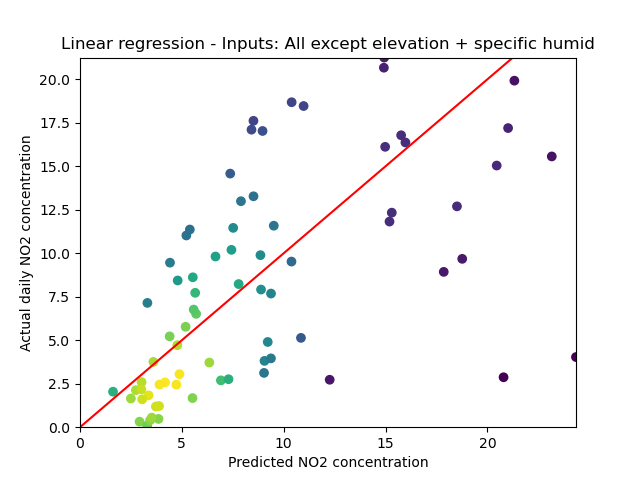

In [45]:
# plot multiple regression fit
%matplotlib widget
linear_predictions = linear_model.predict(X_test_l) 

# Calculate the point density
xy = np.vstack([linear_predictions,y_test_l])
z = gaussian_kde(xy)(xy)

plt.title('Linear regression - Inputs: All except elevation + specific humid')
plt.scatter(linear_predictions, y_test_l, c=z)
plt.plot(np.arange(0, 60, 0.1), np.arange(0, 60, 0.1), c='red')
plt.xlim(0, np.max(linear_predictions))
plt.ylim(0, np.max(y_test_l))
plt.xlabel('Predicted NO2 concentration')
plt.ylabel('Actual daily NO2 concentration')
plt.text(1, 50, 'R2 = %s' % round(r2_score(y_test_l, linear_predictions), 2), fontsize='large')